### ✅ 라이브러리 호출

In [64]:
# 데이터 분석 라이브러리
import pandas as pd
import numpy as np
# 시각화 라이브러리
import matplotlib.pyplot as plt
# 파라미터 튜닝 라이브러리
import optuna
# XAI 라이브러리
from alibi.explainers import ALE, plot_ale
# 모델 훈련 라이브러리
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# 데이터 증강 라이브러리
from imblearn.over_sampling import SMOTE

In [7]:
df = pd.read_csv('malicious_phish_data_step3.csv')
df.head()

,type,len_url,len_sub_domain,len_root_domain,len_suffix,is_private,count_special_char,num_port,len_query,count_sub_domain,is_filter,ratio_alpha_numeric,count_url_dots,value_entropy_url,count_file_path
0,1,0.032258,0.000000,0.137931,0.222222,0.0,0.041667,0.0,0.000000,0.0,0.0,0.000000,0.117647,0.263965,0.000000
1,0,0.100358,0.000000,0.137931,0.055556,0.0,0.041667,0.0,0.000000,0.0,1.0,0.081081,0.117647,0.476386,0.133333
2,0,0.086022,0.000000,0.155172,0.055556,0.0,0.000000,0.0,0.000000,0.0,1.0,0.080000,0.117647,0.364450,0.200000
3,1,0.290323,0.025641,0.137931,0.000000,0.0,0.416667,0.0,0.202479,0.1,1.0,0.222222,0.000000,0.651719,0.066667
4,1,0.817204,0.000000,0.310345,0.055556,0.0,0.291667,0.0,0.801653,0.0,1.0,0.221106,0.117647,0.902395,0.066667


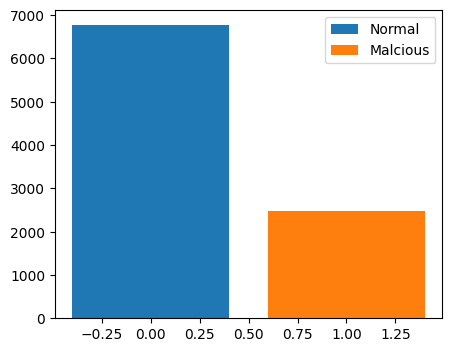

In [23]:
# 데이터가 불균형을 이루고 있습니다.
type_distribution = df['type'].value_counts().values
plt.figure(figsize=(5, 4))
plt.bar([0], type_distribution[0])
plt.bar([1], type_distribution[1])
plt.legend(['Normal', 'Malcious'])

In [48]:
# 따라서 stratify로 균형있게 세트를 나눠줄게요.
X = df.drop(columns='type')
y = df['type']

train_input, test_input, train_target, test_target = train_test_split(X, y, random_state=42, 
                                                                      stratify=y, test_size=.2)

---

### ✅ 파라미터 튜닝 및 성능 개선

/Users/janghongseo/PycharmProjects/AI_Malcious/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/janghongseo/PycharmProjects/AI_Malcious/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/janghongseo/PycharmProjects/AI_Malcious/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/janghongseo/PycharmProjects/AI_Malcious/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/janghongseo/PycharmProjects/AI_Malcious/.venv/lib

array([[<Axes: xlabel='len_url', ylabel='ALE'>,
        <Axes: xlabel='len_sub_domain', ylabel='ALE'>,
        <Axes: xlabel='len_root_domain', ylabel='ALE'>],
       [<Axes: xlabel='len_suffix', ylabel='ALE'>,
        <Axes: xlabel='is_private', ylabel='ALE'>,
        <Axes: xlabel='count_special_char', ylabel='ALE'>],
       [<Axes: xlabel='num_port', ylabel='ALE'>,
        <Axes: xlabel='len_query', ylabel='ALE'>,
        <Axes: xlabel='count_sub_domain', ylabel='ALE'>],
       [<Axes: xlabel='is_filter', ylabel='ALE'>,
        <Axes: xlabel='ratio_alpha_numeric', ylabel='ALE'>,
        <Axes: xlabel='count_url_dots', ylabel='ALE'>],
       [<Axes: xlabel='value_entropy_url', ylabel='ALE'>,
        <Axes: xlabel='count_file_path', ylabel='ALE'>, None]],
      dtype=object)

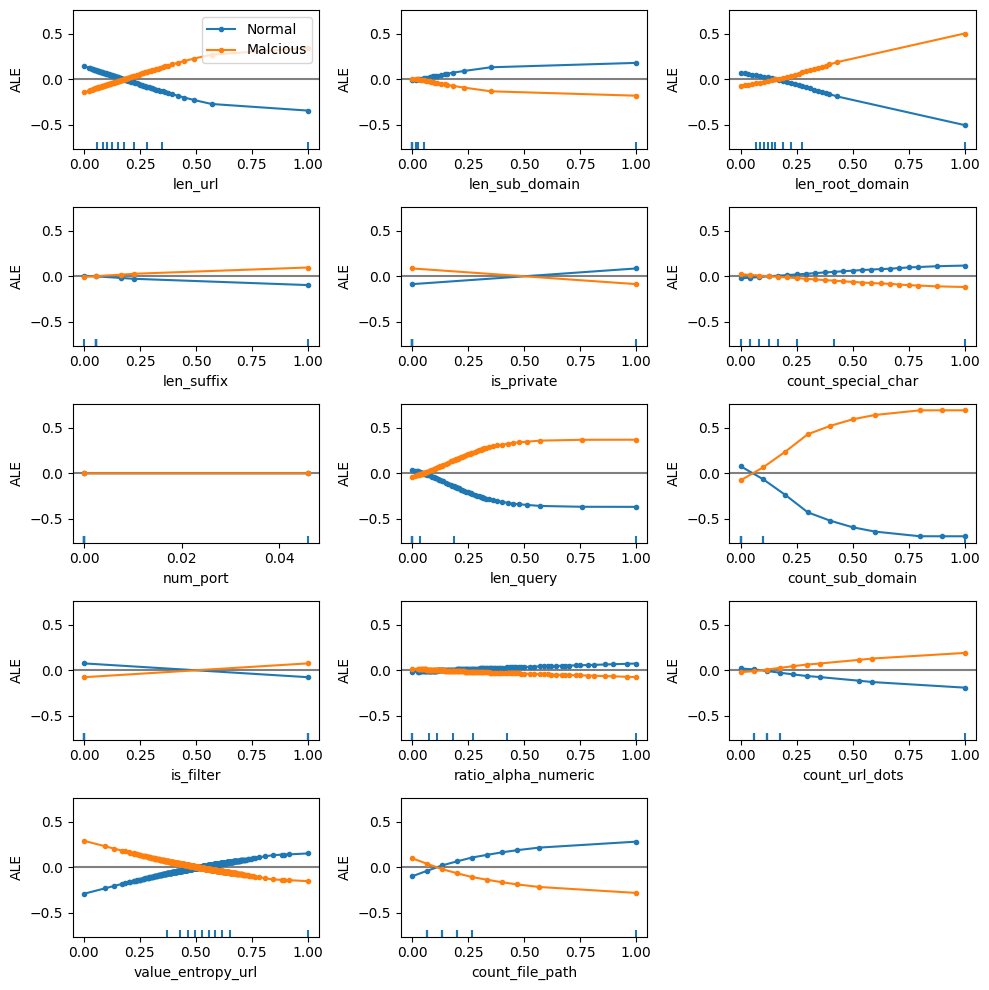

In [42]:
# 변수와 타깃의 상관도를 파악해 보겠습니다.
lr = LogisticRegression()
lr.fit(train_input, train_target)

# ale 적용하기
lr_ale = ALE(predictor=lr.predict_proba, feature_names=train_input.columns, target_names=['Normal', 'Malcious'])
lr_exp = lr_ale.explain(train_input.values)

# 그래프 그리기
plot_ale(exp=lr_exp, n_cols=3, fig_kw={'figwidth':10, 'figheight':10})

In [49]:
# 따라서 stratify로 균형있게 세트를 나눠줄게요.
X = df.drop(columns=['num_port', 'is_filter', 'is_private', 'type'])
y = df['type']

train_input, test_input, train_target, test_target = train_test_split(X, y, random_state=42, 
                                                                      stratify=y, test_size=.2)

In [53]:
# 파라미터 튜닝을 진행할게요!
def objective_gbc(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    }
    model = GradientBoostingClassifier(**params)
    
    score = cross_val_score(model, train_input, train_target, cv=5, scoring="accuracy").mean()
    return score

def objective_hgbc(trial):
    params = {
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
    }
    model = HistGradientBoostingClassifier(**params)

    
    score = cross_val_score(model, train_input, train_target, cv=5, scoring="accuracy").mean()
    return score

def objective_rfc(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }
    model = RandomForestClassifier(**params)

    
    score = cross_val_score(model, train_input, train_target, cv=5, scoring="accuracy").mean()
    return score

def tune_model(objective_func, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_func, n_trials=n_trials)
    print("Best Params:", study.best_trial.params)
    return study.best_trial.params

if __name__ == "__main__":
    print("Tuning GradientBoostingClassifier...")
    best_params_gbc = tune_model(objective_gbc, n_trials=20)
    
    print("Tuning HistGradientBoostingClassifier...")
    best_params_hgbc = tune_model(objective_hgbc, n_trials=20)
    
    print("Tuning RandomForestClassifier...")
    best_params_rfc = tune_model(objective_rfc, n_trials=20)

[I 2025-04-04 16:07:10,733] A new study created in memory with name: no-name-a9e8b562-bbb9-42a5-b9dd-479a7309739d


Tuning GradientBoostingClassifier...


[I 2025-04-04 16:07:18,580] Trial 0 finished with value: 0.9510555890576174 and parameters: {'n_estimators': 101, 'learning_rate': 0.1536071592661357, 'max_depth': 5, 'subsample': 0.9511537130340644}. Best is trial 0 with value: 0.9510555890576174.
[I 2025-04-04 16:07:31,852] Trial 1 finished with value: 0.9494324141585805 and parameters: {'n_estimators': 203, 'learning_rate': 0.2145606631722083, 'max_depth': 6, 'subsample': 0.595902433471506}. Best is trial 0 with value: 0.9510555890576174.
[I 2025-04-04 16:07:39,623] Trial 2 finished with value: 0.9510554976883577 and parameters: {'n_estimators': 75, 'learning_rate': 0.13398499754257695, 'max_depth': 9, 'subsample': 0.5384639847369446}. Best is trial 0 with value: 0.9510555890576174.
[I 2025-04-04 16:07:54,628] Trial 3 finished with value: 0.9513254938508486 and parameters: {'n_estimators': 136, 'learning_rate': 0.1379931587433952, 'max_depth': 7, 'subsample': 0.9345259447339718}. Best is trial 3 with value: 0.9513254938508486.
[I 20

Best Params: {'n_estimators': 251, 'learning_rate': 0.050529424240407114, 'max_depth': 8, 'subsample': 0.6419092148826784}
Tuning HistGradientBoostingClassifier...


[I 2025-04-04 16:12:45,048] Trial 0 finished with value: 0.9506493613288745 and parameters: {'max_iter': 250, 'learning_rate': 0.26875842220981055, 'max_depth': 4}. Best is trial 0 with value: 0.9506493613288745.
[I 2025-04-04 16:13:05,442] Trial 1 finished with value: 0.9515959468596386 and parameters: {'max_iter': 130, 'learning_rate': 0.22116124406767593, 'max_depth': 8}. Best is trial 1 with value: 0.9515959468596386.
[I 2025-04-04 16:13:14,742] Trial 2 finished with value: 0.949432871004879 and parameters: {'max_iter': 155, 'learning_rate': 0.11977198901235556, 'max_depth': 4}. Best is trial 1 with value: 0.9515959468596386.
[I 2025-04-04 16:13:19,649] Trial 3 finished with value: 0.9506497268059133 and parameters: {'max_iter': 133, 'learning_rate': 0.1760716804464263, 'max_depth': 3}. Best is trial 1 with value: 0.9515959468596386.
[I 2025-04-04 16:13:54,381] Trial 4 finished with value: 0.9520011695265247 and parameters: {'max_iter': 231, 'learning_rate': 0.28934866397958586, 'm

Best Params: {'max_iter': 300, 'learning_rate': 0.12008349324318057, 'max_depth': 9}
Tuning RandomForestClassifier...


[I 2025-04-04 16:22:31,261] Trial 0 finished with value: 0.950379182427864 and parameters: {'n_estimators': 245, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.950379182427864.
[I 2025-04-04 16:22:35,766] Trial 1 finished with value: 0.9506494526981342 and parameters: {'n_estimators': 128, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9506494526981342.
[I 2025-04-04 16:22:39,573] Trial 2 finished with value: 0.9303678526396579 and parameters: {'n_estimators': 209, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9506494526981342.
[I 2025-04-04 16:22:48,321] Trial 3 finished with value: 0.9505145003015185 and parameters: {'n_estimators': 245, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9506494526981342.
[I 2025-04-04 16:22:56,662] Trial 4 finished with value: 0.9484861941048554 and parameters: {'n

Best Params: {'n_estimators': 115, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 1}


In [55]:
last_gbc = GradientBoostingClassifier(**best_params_gbc)
last_hgbc = HistGradientBoostingClassifier(**best_params_hgbc)
last_rfc = RandomForestClassifier(**best_params_rfc)
hard_vote = VotingClassifier(voting='hard', estimators=[('gbc', last_gbc),
                                                        ('hgbc', last_hgbc),
                                                        ('rfc', last_rfc)])
hard_vote.fit(train_input, train_target)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.050529424240407114,
                                                         max_depth=8,
                                                         n_estimators=251,
                                                         subsample=0.6419092148826784)),
                             ('hgbc',
                              HistGradientBoostingClassifier(learning_rate=0.12008349324318057,
                                                             max_depth=9,
                                                             max_iter=300)),
                             ('rfc',
                              RandomForestClassifier(max_depth=17,
                                                     min_samples_split=8,
                                                     n_estimators=115))])

In [56]:
print(f'하드 보팅 결과(훈련)는 : {hard_vote.score(train_input, train_target)}')
print(f'하드 보팅 결과(테스트)는 : {hard_vote.score(test_input, test_target)}')

하드 보팅 결과(훈련)는 : 0.9994591671173607
하드 보팅 결과(테스트)는 : 0.9626825310978907


---

### ✅ 심화학습 및 결론

In [60]:
# SMOTE 기법 적용
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_aug, target_aug = smote.fit_resample(train_input, train_target)

# 모델 학습
panda_model = VotingClassifier(voting='hard', estimators=[('gbc', last_gbc),
                                                          ('hgbc', last_hgbc),
                                                          ('rfc', last_rfc)])
panda_model.fit(train_aug, target_aug)

# 성능 평가
print(f"PANDA-SMOTE Train Accuracy: {panda_model.score(train_input, train_target):.4f}")
print(f"PANDA-SMOTE Test Accuracy: {panda_model.score(test_input, test_target):.4f}")

PANDA-SMOTE Train Accuracy: 0.9859
PANDA-SMOTE Test Accuracy: 0.9611


---

### ✅ 결정경계 도식화

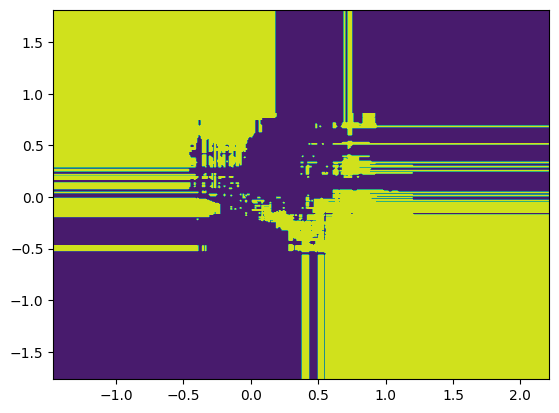

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_input)
test_pca = pca.transform(test_input)

x_min, x_max = train_pca[:, 0].min()-1, train_pca[:, 0].max()+1
y_min, y_max = train_pca[:, 1].min()-1, train_pca[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

hard_vote = VotingClassifier(voting='hard', estimators=[('gbc', last_gbc),
                                                        ('hgbc', last_hgbc),
                                                        ('rfc', last_rfc)])
hard_vote.fit(train_pca, train_target)
z = hard_vote.predict(np.array([xx.ravel(), yy.ravel()]).T)
z = z.reshape(xx.shape)
plt.contourf(xx, yy, z)

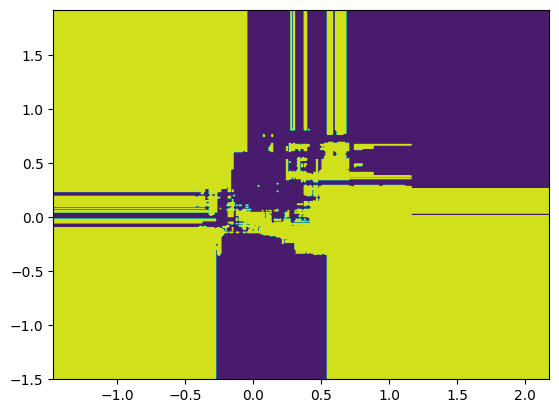

In [67]:
train_pca_aug = pca.fit_transform(train_aug)
test_pca = pca.transform(test_input)

x_min, x_max = train_pca_aug[:, 0].min()-1, train_pca_aug[:, 0].max()+1
y_min, y_max = train_pca_aug[:, 1].min()-1, train_pca_aug[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

hard_vote = VotingClassifier(voting='hard', estimators=[('gbc', last_gbc),
                                                        ('hgbc', last_hgbc),
                                                        ('rfc', last_rfc)])
hard_vote.fit(train_pca_aug, target_aug)
z = hard_vote.predict(np.array([xx.ravel(), yy.ravel()]).T)
z = z.reshape(xx.shape)
plt.contourf(xx, yy, z)